## Набор данных электронной почты Enron Corporation
* Содержит 517'401 электронных писем, сгенерированных сотрудниками корпорации Enron
* Он был получен Федеральной комиссией по регулированию энергетики в ходе расследования краха Enron

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# define GPU for BERT model
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import wordcloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
import spacy
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.callbacks import PerplexityMetric
from tqdm.notebook import tqdm
import pyLDAvis.gensim
import gensim.downloader as api
from gensim.models import Word2Vec
import gensim
import numpy as np
from sklearn.cluster import KMeans
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from bokeh.io import output_notebook
import bokeh.models as bm, bokeh.plotting as pl
from nltk.tokenize import WordPunctTokenizer
from multiprocessing import Pool
from bs4 import BeautifulSoup
import re
from collections import defaultdict

In [3]:
# from spacy.cli.download import download
# download(model="en_core_web_sm")
# nltk.download('stopwords')

In [4]:
df = pd.read_csv('emails.csv')

In [5]:
df.head(3)

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...


In [6]:
msg = df['message'][0]

In [7]:
print(msg)

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


## Чтобы вручную такое не парсить, будем использовать библиотеку email

In [8]:
import email

In [9]:
'Email object keys: %s' % email.message_from_string(msg).keys()

"Email object keys: ['Message-ID', 'Date', 'From', 'To', 'Subject', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding', 'X-From', 'X-To', 'X-cc', 'X-bcc', 'X-Folder', 'X-Origin', 'X-FileName']"

In [10]:
def get_text_from_email(msg_text):
    '''To get the content from email objects'''
    
    msg = email.message_from_string(msg_text)
    parts = [part.get_payload() for part in msg.walk() if \
             part.get_content_type() == 'text/plain']
    return ''.join(parts)

In [11]:
get_text_from_email(msg)

'Here is our forecast\n\n '

In [12]:
df['Content'] = list(map(get_text_from_email, df['message']))

messages = list(map(email.message_from_string, df['message']))
for key in ['Date', 'From', 'To', 'Subject']:
    df[key] = [doc[key] for doc in messages]

In [13]:
def split_email_addresses(line):
    '''To separate multiple email addresses'''
    
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs


def convert_date(data):
    # https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    return pd.to_datetime(data).tz_convert(None).strftime('%a %d %b %Y %H:%M:%S')


df['User'] = df['file'].map(lambda x: x.split('/')[0])
df.drop(['file', 'message'], axis=1, inplace=True)
df['From'] = df['From'].map(split_email_addresses)
df['To'] = df['To'].map(split_email_addresses)

df['Date'] = df['Date'].apply(convert_date)
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [14]:
df.sample(3)

,Content,Date,From,To,Subject,User
369627,Byob,2001-06-19 21:17:25,(cooper.richey@enron.com),None,Hawker bday,richey-c
90660,---------------------- Forwarded by David W De...,2000-11-08 11:52:00,(david.delainey@enron.com),(kay.chapman@enron.com),Approval for reviewer,delainey-d
146103,"Group,\n\nI have created some new procedures f...",2001-02-05 05:31:00,(monika.causholli@enron.com),(portland.shift@enron.com),Reports Procedures,guzman-m


### Пример письма до чистки текста:

In [15]:
df['Content'].iloc[48]

'---------------------- Forwarded by Phillip K Allen/HOU/ECT on 09/12/2000 \n11:22 AM ---------------------------\n\nMichael Etringer\n\n09/11/2000 02:32 PM\n\nTo: Phillip K Allen/HOU/ECT@ECT\ncc:  \nSubject: Contact list for mid market\n\nPhillip,\nAttached is the list.  Have your people fill in the columns highlighted in \nyellow.  As best can we will try not to overlap on accounts. \n\nThanks, Mike\n\n\n'

In [16]:
def good_word(word):
    for c in word:
        if '0' <= c <= '9':
            return False
        
    return True

def clean_text(text):
    x = text
    text = nltk.RegexpTokenizer('\s+', gaps=True).tokenize(text.lower())
    text = ' '.join([word for word in text if good_word(word)])

    text = re.sub('<.*>', '', text) # text inside <>, some forwarded info
    text = re.sub('\[.*\]', '', text) # text inside [], this is some attachements
    text = re.sub('\S*@\S*\s?', '', text) # remote email addresses
    text = re.sub('\S*/hou/\S*s?', '', text) # some corporation usernames
    text = re.sub('http[s]?://\S+', '', text) # remove links
    text = re.sub('www\.\S+', '', text) # remove links

    
    # text = re.sub('.*subject:', '', text) # remain only text subject [works too long, let's implement]
    
    msg_text = 'subject:'
    idx = text.find(msg_text)
    if idx != -1:
        text = text[idx + len(msg_text):].strip()
    
    return text

for field in ['Content', 'Subject']:
    df[field] = [clean_text(email) for email in df[field]]

<>:10: DeprecationWarning: invalid escape sequence \s
<>:14: DeprecationWarning: invalid escape sequence \[
<>:15: DeprecationWarning: invalid escape sequence \S
<>:16: DeprecationWarning: invalid escape sequence \S
<>:17: DeprecationWarning: invalid escape sequence \S
<>:18: DeprecationWarning: invalid escape sequence \.
<>:10: DeprecationWarning: invalid escape sequence \s
<>:14: DeprecationWarning: invalid escape sequence \[
<>:15: DeprecationWarning: invalid escape sequence \S
<>:16: DeprecationWarning: invalid escape sequence \S
<>:17: DeprecationWarning: invalid escape sequence \S
<>:18: DeprecationWarning: invalid escape sequence \.
<ipython-input-16-18790927da10>:10: DeprecationWarning: invalid escape sequence \s
  text = nltk.RegexpTokenizer('\s+', gaps=True).tokenize(text.lower())
<ipython-input-16-18790927da10>:14: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[.*\]', '', text) # text inside [], this is some attachements
<ipython-input-16-18790927da10>:15:

### Пример письма после чистки текста:

In [17]:
df['Content'].iloc[48]

'contact list for mid market phillip, attached is the list. have your people fill in the columns highlighted in yellow. as best can we will try not to overlap on accounts. thanks, mike'

### Теперь посмотрим на распределение длин писем (по количеству слов)

There are 2968 sentences with length >= 500


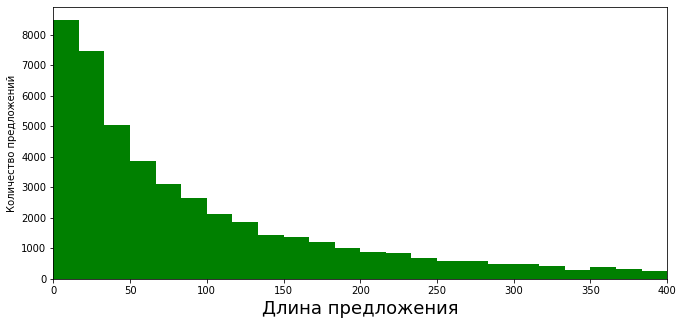

In [100]:
# нужно перезапустить эту ячейку

sentence_lengths = [min(500, len(s.split())) for s in df['Content']]

cnt = 0
for x in sentence_lengths:
    if x == 500:
        cnt += 1
        
        
print('There are %s sentences with length >= 500' % cnt)

plt.figure(figsize=(11, 5))
plt.hist(sentence_lengths, bins=30, color='green')
plt.xlabel('Длина предложения', fontsize=18)
plt.ylabel('Количество предложений')
plt.xlim(0, 400)
plt.show()

## Когда люди отсылали письма?

Text(0, 0.5, 'N emails')

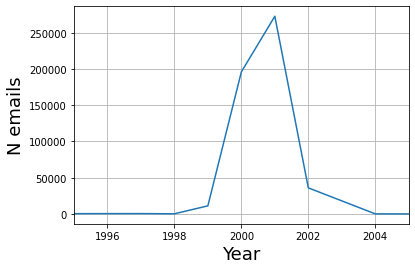

In [18]:
ax = df.groupby(df['Date'].dt.year)['Content'].count().plot(xlim=(1995, 2005), grid=True)
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

Text(0, 0.5, 'N emails')

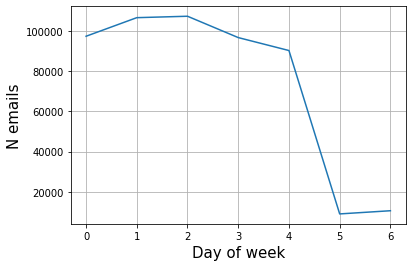

In [19]:
ax = df.groupby(df['Date'].dt.dayofweek)['Content'].count().plot(grid=True)
ax.set_xlabel('Day of week', fontsize=15)
ax.set_ylabel('N emails', fontsize=15)

Text(0, 0.5, 'N emails')

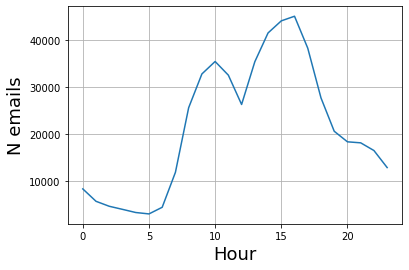

In [20]:
ax = df.groupby(df['Date'].dt.hour)['Content'].count().plot(grid=True)
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)

## О чём говорится в письмах?

In [21]:
def plot_wordcloud(text):
    fig, ax = plt.subplots(figsize=(16, 10))
    wc = wordcloud.WordCloud(width=1200, 
                             height=750, 
                             max_words=200,
                             stopwords=list(ENGLISH_STOP_WORDS)).generate(text)
    ax.imshow(wc)
    ax.axis("off")
    # print(wc.words_)

## В темах писем

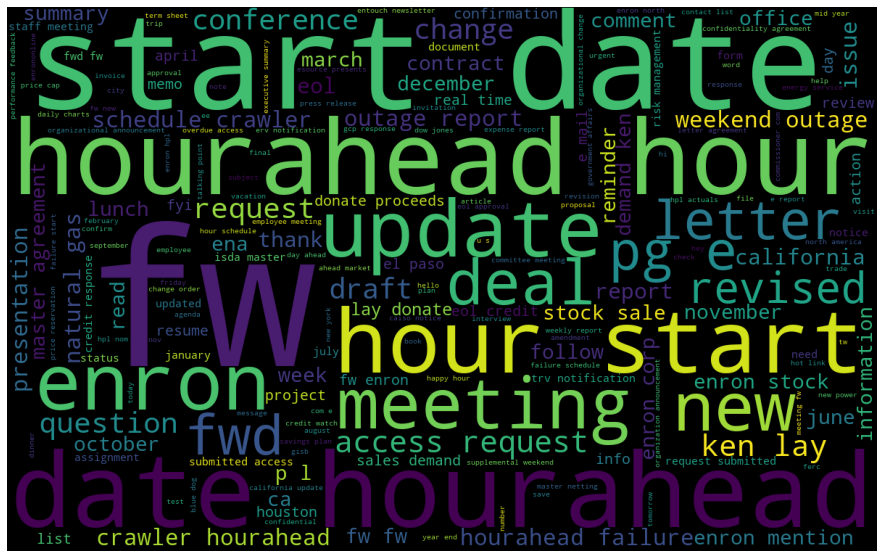

In [22]:
subjects = ' '.join(df['Subject'])
plot_wordcloud(subjects)

## В содержании писем

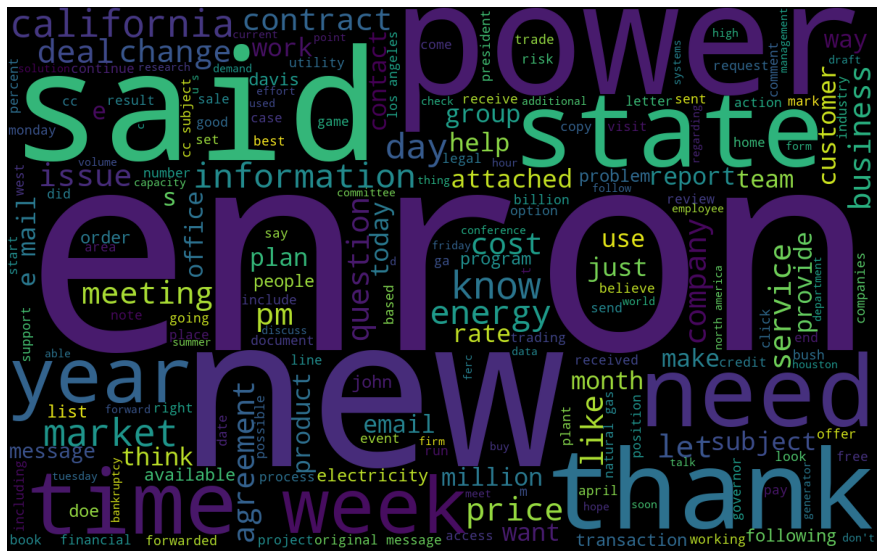

In [23]:
contents = ' '.join(df.sample(1000)['Content'])
plot_wordcloud(contents)

## Анализ отправителей и получателей писем

### Топ-20 адресов, с которых было отправлено наибольшее количество электронных писем

In [24]:
cnt = defaultdict(int) 
for item in df['From']:
    sender = list(item)[0]
    sender = sender[:sender.rfind('.')]
    cnt[sender] += 1

In [25]:
users, counts = zip(*sorted(cnt.items(), key=lambda x: x[1], reverse=True)[:20])

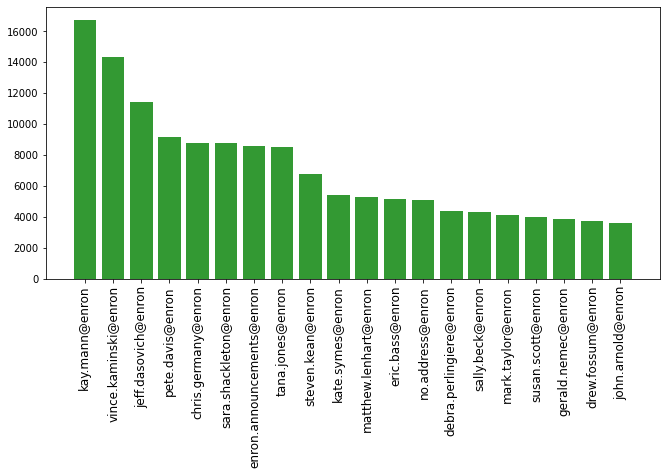

In [26]:
plt.figure(figsize=(11, 5))
plt.bar(range(20), counts, align='center', color='green', alpha=0.8)
plt.xticks(range(20), users, rotation='vertical', fontsize=12)
plt.show()

### Топ-20 адресов, на которые было отправлено наибольшее количество электронных писем

In [27]:
bad_cnt = 0
for item in df['To']:
    if item is None:
        bad_cnt += 1
        continue
        
    for x in item:
        receiver = x[:x.rfind('.')]
    cnt[receiver] += 1
print('There is %s emails without receivers' % bad_cnt)

There is 21847 emails without receivers


In [28]:
users, counts = zip(*sorted(cnt.items(), key=lambda x: x[1], reverse=True)[:20])

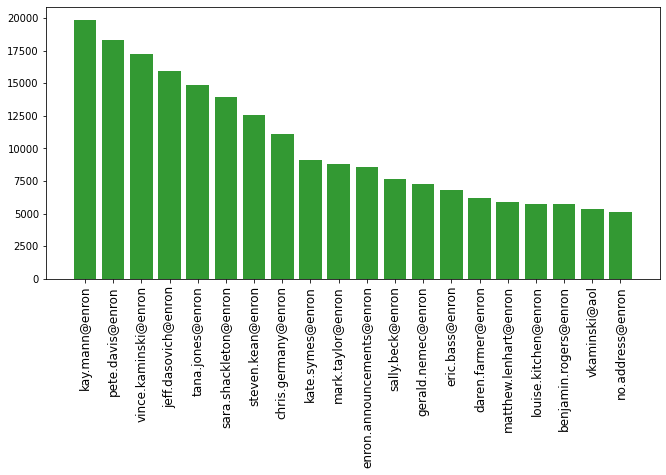

In [29]:
plt.figure(figsize=(11, 5))
plt.bar(range(20), counts, align='center', color='green', alpha=0.8)
plt.xticks(range(20), users, rotation='vertical', fontsize=12)
plt.show()

### Как видим, в графиках распределения получателей и отправителей писем много различий - какие-то люди писем меньше пишут, чем получают и наоборот

### Теперь посмотрим парные количества. Сначала мы рассмотрим только электронные письма, отправленные на один адрес электронной почты, которые могут быть более важными личными сообщениями

In [30]:
sub_df = df[['From', 'To', 'Date']].dropna()
print(sub_df.shape)

# drop emails sending to multiple addresses
sub_df = sub_df.loc[sub_df['To'].map(len) == 1]
print(sub_df.shape)

(495554, 3)
(354600, 3)


In [31]:
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()

# unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))

# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)
sub_df.sort_values('count', ascending=False).head(10)

,From,To,count
17908,pete.davis@enron.com,pete.davis@enron.com,9141
38033,vince.kaminski@enron.com,vkaminski@aol.com,4308
28920,enron.announcements@enron.com,all.worldwide@enron.com,2206
28935,enron.announcements@enron.com,all.houston@enron.com,1701
26510,kay.mann@enron.com,suzanne.adams@enron.com,1528
38031,vince.kaminski@enron.com,shirley.crenshaw@enron.com,1190
14564,steven.kean@enron.com,maureen.mcvicker@enron.com,1014
26309,kay.mann@enron.com,nmann@erac.com,980
18926,kate.symes@enron.com,evelyn.metoyer@enron.com,915
18930,kate.symes@enron.com,kerri.thompson@enron.com,859


### Как видим, некоторые люди отправляют себе много электронных писем

### Интересно посмотреть на эти взаимосвязи в виде графа

In [32]:
import networkx as nx

G = nx.from_pandas_edgelist(sub_df, 'From', 'To', edge_attr='count', create_using=nx.DiGraph())
print('Number of nodes: %s, Number of edges: %s' % (G.number_of_nodes(), G.number_of_edges()))

Number of nodes: 25396, Number of edges: 56144


Text(0.5, 0, 'Степень выхода вершин')

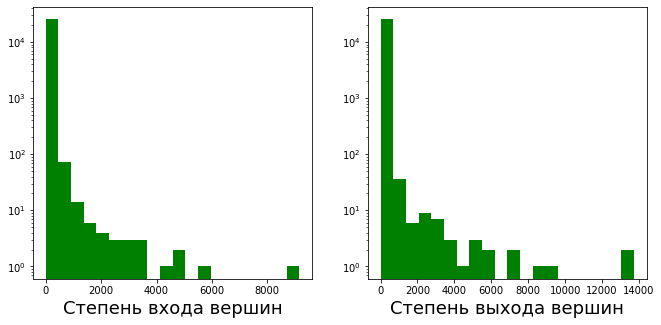

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11, 5))
ax1.hist(list(dict(G.in_degree(weight='count')).values()), log=True, bins=20, color='green')
ax1.set_xlabel('Степень входа вершин', fontsize=18)

ax2.hist(list(dict(G.out_degree(weight='count')).values()), log=True, bins=20, color='green')
ax2.set_xlabel('Степень выхода вершин', fontsize=18)

В графе 1430 связных компонент


(0.1, 10000.0)

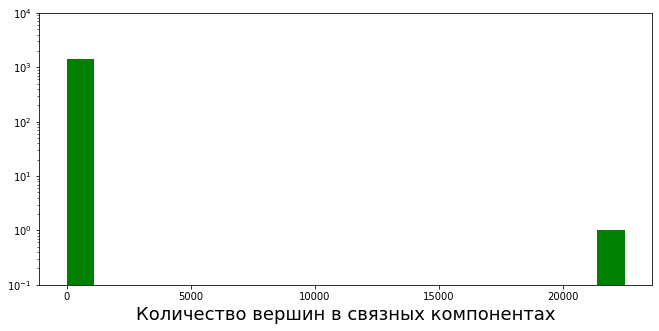

In [34]:
comp_sizes = []
for nodes in nx.connected_components(G.to_undirected()):
    comp_sizes.append(len(nodes))
    
print('В графе %s связных компонент' % len(comp_sizes))

plt.figure(figsize=(11, 5))
plt.hist(comp_sizes, bins=20, log=True, color='green')
plt.xlabel('Количество вершин в связных компонентах', fontsize=18)
plt.ylim([0.1, 1e4])


In [35]:
df = df.head(50000)

## Тематическое моделирование c LDA model

### Для начала слова нормализуем

In [36]:
def normalize(word):
    return nlp(word)[0].lemma_

In [37]:
nlp = spacy.load("en_core_web_sm")
normalize('dogs'), normalize('playing')

('dog', 'play')

In [38]:
emails = list(df['Content'])
emails = [nltk.RegexpTokenizer(r'\w+').tokenize(email.lower()) for email in emails]

In [39]:
stop_words = set(nltk.corpus.stopwords.words('english'))

def f(email_words):
    return [normalize(word) for word in email_words if word not in stop_words]

n_cpu = 70
with Pool(n_cpu) as p:
    emails = p.map(f, emails)

emails = [email_words for email_words in emails if len(email_words) > 2]
print(f'Total emails extracted: {len(emails)}')

Total emails extracted: 47566


In [39]:
dictionary = corpora.Dictionary(emails)
corpus = [dictionary.doc2bow(email_words) for email_words in emails]

In [40]:
def f(num_topics):
    perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')

    lda = LdaModel(corpus, id2word=dictionary, num_topics=num_topics, callbacks=[perplexity_logger],
                   iterations=200, passes=10)

    return perplexity_logger.get_value()
    
rng = range(3, 10)
n_cpu = len(rng)
with Pool(n_cpu) as p:
    pps = p.map(f, rng)

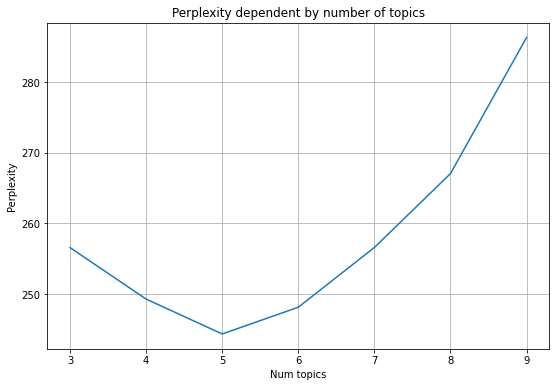

In [41]:
plt.figure(figsize=(9, 6))
plt.plot(rng, pps)
plt.xlabel('Num topics')
plt.ylabel('Perplexity')
plt.title('Perplexity dependent by number of topics')
plt.grid()
plt.show()

In [42]:
def show(model):
    str_topics = [topic_w for topic_number, topic_w in model.print_topics()]
    str_topics_split = list(map(lambda x: x.split("+"), str_topics))
    str_topics_split = [list(map(lambda x: x.split("*")[1].strip()[1:-1], elem)) for elem in str_topics_split]
    for topic in str_topics_split:
        print(', '.join(topic))

In [43]:
best_num_topics = rng[np.argmin(pps)]
lda = LdaModel(corpus, id2word=dictionary, num_topics=best_num_topics, iterations=200, passes=10)

In [44]:
show(lda)

get, go, week, good, one, see, like, look, think, make
please, thank, meet, send, subject, enron, would, message, know, pm
enron, company, page, employee, would, state, say, issue, year, labor
please, mail, click, email, time, order, e, information, com, receive
enron, pm, schedule, outage, business, system, risk, market, power, london


### Что мы видим:
* в 1м топике сосредоточены глаголы
* в 4м про письма

### Интерпретируемости получили не очень много, LDA модель сработала не очень хорошо

In [102]:
data_lda = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(data_lda)

## Кластеризация word2vec embeddings

In [40]:
path = api.load("glove-twitter-50", return_path=True)

In [41]:
model = KeyedVectors.load_word2vec_format(path)

In [ ]:
model_2 = Word2Vec(size=50, min_count=1)
model_2.build_vocab(emails)
total_examples = model_2.corpus_count
model_2.build_vocab([list(model.vocab.keys())], update=True)
model_2.intersect_word2vec_format(path)

In [43]:
model_2.train(emails, total_examples=total_examples, epochs=5)

(23734080, 23746090)

In [44]:
words = np.array(list(set((" ".join([" ".join(x) for x in emails])).split())))

In [45]:
word_vectors = []
bad_count = 0
for x in words:
    try:
        vec = model_2.wv.get_vector(x)
    except KeyError:
        bad_count += 1
        vec = np.zeros(50)
    word_vectors.append(vec)
print('There are %s words from %s without embeddings' % (bad_count, len(words)))

There are 0 words from 49877 without embeddings


In [46]:
kmeans = KMeans(n_clusters=2000, n_jobs=70)
kmeans.fit(word_vectors)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=2000, n_jobs=70)

In [47]:
def show_cluster(num):
    inds = np.where(kmeans.labels_ == num)
    print('Размер кластера: %s, слова: %s' % (len(words[inds]), words[inds][:20]))
    print()

### Интересный кластер, хоть слова написаны и с опечаткой, модель смогла понять что они встречаются в похожих контекстах:

In [103]:
show_cluster(1997)

Размер кластера: 2, слова: ['someth' 'somethi']



### Кластер прилагательных, немного связанных с бизнесом:

In [105]:
show_cluster(8)

Размер кластера: 21, слова: ['deport' 'investigate' 'threaten' 'disclose' 'detain' 'withdraw'
 'abandon' 'smuggle' 'bribe' 'hijack' 'evacuate' 'intervene' 'negotiate'
 'liable' 'nuke' 'urge' 'locate' 'confiscate' 'violate' 'warn']



### Кластер плохих слов:

In [106]:
show_cluster(9)

Размер кластера: 19, слова: ['shut' 'fuck' 'ass' 'swear' 'dude' 'lol' 'fuckin' 'outta' 'hell' 'mad'
 'broke' 'suck' 'damn' 'bitch' 'shit' 'tf' 'kill' 'lmao' 'tho']



### А также ещё некоторые

In [110]:
show_cluster(95)

Размер кластера: 11, слова: ['lover' 'dreamer' 'destiny' 'pride' 'confident' 'humble' 'shine'
 'gentleman' 'motto' 'soul' 'believer']



In [109]:
show_cluster(1902)

Размер кластера: 12, слова: ['illness' 'depression' 'apparent' 'disorder' 'anxiety' 'traumatic'
 'stigma' 'harm' 'prone' 'suffer' 'preventable' 'psychological']



In [108]:
show_cluster(180)

Размер кластера: 11, слова: ['march' 'august' 'october' 'april' 'september' 'june' 'february'
 'december' 'july' 'november' 'january']



In [49]:
# word_vectors_pca = TSNE(n_components=2, n_jobs=40).fit_transform(word_vectors)
word_vectors_pca = PCA(n_components=2).fit_transform(word_vectors)

word_vectors_pca = StandardScaler().fit_transform(word_vectors_pca)

output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

Loading BokehJS ...

Figure(id='1004', ...)

In [50]:
model_2.wv.most_similar('russia')

[('ukraine', 0.8960039019584656),
 ('canada', 0.8308505415916443),
 ('russian', 0.8201991319656372),
 ('sweden', 0.8108468651771545),
 ('moscow', 0.8099092245101929),
 ('greece', 0.8071787357330322),
 ('norway', 0.8041681051254272),
 ('zealand', 0.8002776503562927),
 ('belgium', 0.7978895902633667),
 ('germany', 0.7861911058425903)]

In [51]:
model_2.wv.most_similar(positive=['queen', 'boy'], negative=['girl'])

[('king', 0.8481787443161011),
 ('prince', 0.847251296043396),
 ('angel', 0.8389350175857544),
 ('lady', 0.8351561427116394),
 ('aka', 0.8251813650131226),
 ('punk', 0.8228825926780701),
 ('princess', 0.8196807503700256),
 ('rock', 0.7763223648071289),
 ('band', 0.7758490443229675),
 ('monster', 0.7747203707695007)]

## Тематическое моделирование c BERTopic

In [52]:
from bertopic import BERTopic

/usr/local/lib/python3.8/dist-packages/packaging/version.py:127: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  warnings.warn(


In [53]:
emails = list(df['Content'])

In [54]:
len(emails)

50000

In [55]:
def tokenize(x):
    return ' '.join(nltk_tokenizer.tokenize(x))

nltk_tokenizer = WordPunctTokenizer()

In [56]:
emails = [tokenize(email) for email in emails]

In [57]:
topic_model = BERTopic()
topics, _ = topic_model.fit_transform(emails)

In [58]:
def show_topic(num):
    return [x[0] for x in topic_model.get_topic(num) if x[1] > 0]

In [117]:
show_topic(100)

['congrats',
 'congratulation',
 'deserving',
 'illustrious',
 'congratulations',
 'peggy']

In [118]:
show_topic(200)

['font',
 'arial',
 'text',
 'bold',
 'disclaimer',
 'serif',
 'decoratio',
 'hover',
 'sans',
 'letterbold']

In [121]:
show_topic(286)

['estimate',
 'improve',
 'managers',
 'salary',
 'priority',
 'create',
 'scheduling',
 'plus',
 'schedule',
 'everyone']

In [125]:
show_topic(1444)

['chromates',
 'hydrocarbons',
 'contamination',
 'petroleum',
 'leaching',
 'soil',
 'aquifers',
 'tank',
 'leaking',
 'waste']

In [126]:
show_topic(1022)

['cream',
 'tyler',
 'oeuvres',
 'beer',
 'cowparade',
 'bar',
 'tastings',
 'honey',
 'ice',
 'wine']

In [68]:
topic_model.visualize_topics()